<a href="https://colab.research.google.com/github/kozen88/HCV_DM23/blob/main/Ottimizzazione_albero_finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ottimizzazione del modello ad albero finale

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sb
sb.set()
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import graphviz
from sklearn import tree
from sklearn.metrics import accuracy_score, roc_auc_score, fbeta_score, precision_score, recall_score, roc_curve
import itertools

fasi preparatorie di caricamento dati e preparazione attributi di input e output

In [ ]:
df = pd.read_csv('HCV_rna12_alt35.csv', delimiter=',')
print(df)

In [12]:
# Preparazione delle feature di input e quelle di output per l'addestramento
X = df.drop('Baselinehistological staging', axis=1)
y = df['Baselinehistological staging']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5097) # discutere con il prof del random state e di come influenza l'addestramento

Andiamo a definire una funzione che prenderà in input il dataframe diviso in train e test e avrà un dizionario con i parametri che vogliamo ottimizzare e le liste di valori da dare in pasto alla funzione affinchè siano testati in combinazione e sia estratta la migliore combinazione. L'estrazione di tali parametri è affidata ad un algoritmo di beam search dove è possibile impostare il numero di beam da portare avantri nella ricerca e il numero di iterazione che si vogliono compiere.

In [13]:
def beam_search(param_space, X_train, y_train, X_val, y_val, beam_width, num_iterations):
    best_params = None
    best_accuracy = 0.0

    # Genera tutte le possibili combinazioni di parametri
    all_param_combinations = list(itertools.product(*param_space.values()))

    # Inizializza il beam con alcune combinazioni di parametri casuali o predefinite
    beam = all_param_combinations[:beam_width]

    for _ in range(num_iterations):
        new_beam = []

        for params in beam:
            # Addestra l'albero decisionale utilizzando i parametri correnti
            tree = DecisionTreeClassifier(**dict(zip(param_space.keys(), params)))
            tree.fit(X_train, y_train)

            # Valuta l'accuratezza sull'insieme di validazione
            y_pred = tree.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)

            # Aggiorna la migliore combinazione di parametri
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = params

            # Genera nuove combinazioni di parametri
            new_param_combinations = list(itertools.product(*[param_space[key] for key in param_space.keys() if key not in params]))
            new_beam.extend(new_param_combinations)

        # Seleziona i k migliori candidati per l'iterazione successiva
        beam = sorted(new_beam, key=lambda x: x[0], reverse=True)[:beam_width]

    return best_params, best_accuracy

In [15]:
test_range = range(2,50)

param_space = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "min_samples_split": test_range,
    "min_samples_leaf": test_range,
    "min_weight_fraction_leaf": [0.0],
    "max_features": [None, "auto", "sqrt", "log2"],
    "max_leaf_nodes": test_range,
    "min_impurity_decrease":[0.0]
}

# Chiamata alla funzione beam_search
best_params, best_accuracy = beam_search(param_space, X_train, y_train, X_test, y_test, beam_width=3, num_iterations=5)

# Stampa i risultati
print("Migliori parametri:", best_params)
print("Accuratezza migliore:", best_accuracy)

Migliori parametri: ('gini', 'best', 2, 2, 0.0, None, 4, 0.0)
Accuratezza migliore: 0.28530259365994237


L'ottimizzazione sembra dare effetti diversi a seconda del random state che viene ad essere immesso attualmente p 5097 e dà risultati con i quali siamo sopra la moda, con altri valori è stato possibile raggiungere anche percentuali di accuratezza superiori al 30%. Il motivo del perchè vi sia questa varianza non è chiaro ed è da approfondire al momento poichè questi parametri hanno portato ad un buon risultato gli utilizziamo per visualizzare l'albero creato con tali parametri.

In [22]:
# Creazione del modello di albero decisionale
final_tree_model = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=2, min_samples_leaf=2,
                                          min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=4,min_impurity_decrease=0.0  )
# Addestramento del modello sui dati di training completi
final_tree_model.fit(X_train, y_train)

# Valutazione del modello sui dati di test
test_accuracy = final_tree_model.score(X_test, y_test)
print("Accuracy sui dati di test:", test_accuracy)

Accuracy sui dati di test: 0.28530259365994237


In [24]:
# andiamo a creare un file formato dot che raccolga le info sull'albero addestrato in modo da
# poter creare un immagine che mostri i nodi dell'albero con le informazioni contenute al suo interno.
dot_data = tree.export_graphviz(final_tree_model, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("albero_decisionale", format='png')

'albero_decisionale.png'

[Text(0.5, 0.8333333333333334, 'x[24] <= 790496.0\ngini = 0.75\nsamples = 1038\nvalue = [247, 249, 270, 272]'),
 Text(0.25, 0.5, 'x[2] <= 32.5\ngini = 0.75\nsamples = 1010\nvalue = [246, 240, 265, 259]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.748\nsamples = 775\nvalue = [183, 169, 208, 215]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.743\nsamples = 235\nvalue = [63, 71, 57, 44]'),
 Text(0.75, 0.5, 'x[18] <= 103.0\ngini = 0.648\nsamples = 28\nvalue = [1, 9, 5, 13]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.54\nsamples = 21\nvalue = [0, 3, 5, 13]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.245\nsamples = 7\nvalue = [1, 6, 0, 0]')]

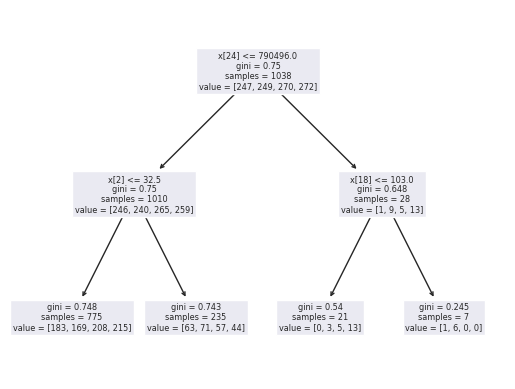

In [25]:
tree.plot_tree(final_tree_model)

In [26]:
# Visualizzazione dell'importanza delle feature
print("Importanza delle feature:")
print(final_tree_model.feature_importances_)

Importanza delle feature:
[0.         0.         0.2799746  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.46842675 0.         0.         0.         0.         0.
 0.25159865 0.         0.         0.        ]


Una volta che abbiamo ottenuto il modello finale e ne stiamo visualizzando tutte le sue caratteristiche andiamo ad eseguire una cross_validation su tale modello finale e vedere i risultati che otteniamo.

In [27]:
# ftm_cval sta per final tree model cross validation
ftm_cval =  DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=2, min_samples_leaf=2,
                                          min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=4,min_impurity_decrease=0.0  )

# usiamo la cross-val
scores_ftm_cval = cross_val_score(ftm_cval, X, y, cv=10)
mean_accurancy_ftm_cval = scores_ftm_cval.mean()
print(scores_ftm_cval)
print(mean_accurancy_ftm_cval)

[0.28057554 0.23741007 0.24460432 0.27338129 0.22302158 0.2173913
 0.26811594 0.26086957 0.26811594 0.25362319]
0.2527108747784381


In [28]:
# Creazione del dataframe per la tabella
data = {
    'Scores': scores_ftm_cval,
    'Mean Accuracy': mean_accurancy_ftm_cval
}
result_table = pd.DataFrame(data)

# Formattazione dei punteggi come stringhe con 2 decimali
result_table['Scores'] = result_table['Scores'].map('{:.2f}'.format)

# Generazione della tabella in formato Markdown
markdown_table = result_table.to_markdown(index=False)

# Stampa della tabella
print(markdown_table)

|   Scores |   Mean Accuracy |
|---------:|----------------:|
|     0.28 |        0.252711 |
|     0.24 |        0.252711 |
|     0.24 |        0.252711 |
|     0.27 |        0.252711 |
|     0.22 |        0.252711 |
|     0.22 |        0.252711 |
|     0.27 |        0.252711 |
|     0.26 |        0.252711 |
|     0.27 |        0.252711 |
|     0.25 |        0.252711 |


In [41]:
# funzione che serve per valutare iterrativamente il modello su dei valori di K per i foldi utilizzati nella
# cross validation
def eval_clf_singleClf(cv_values, model, X, y):
    print("Classifier:", model.__class__.__name__)
    for cv in cv_values:
        scores = cross_val_score(model, X, y, cv=cv)
        mean_accuracy = scores.mean()
        print("CV:", cv)
        print("Mean Accuracy:", mean_accuracy)
        print("Scores:", scores)
        print("__________________________________________________________________________")
        print("##########################################################################")
        print(" ")

In [36]:
values = [5, 10, 15, 20]
# Creazione del modello di albero decisionale
fTM = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=2, min_samples_leaf=2,
                                          min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=4,min_impurity_decrease=0.0  )
# Addestramento del modello sui dati di training completi
eval_clf_singleClf(values, fTM, X, y)

Classifier: DecisionTreeClassifier
CV: 5
Mean Accuracy: 0.25270758122743686
Scores: [0.27075812 0.24909747 0.23465704 0.27075812 0.23826715]
__________________________________________________________________________
##########################################################################
 
CV: 10
Mean Accuracy: 0.2527108747784381
Scores: [0.28057554 0.23741007 0.24460432 0.27338129 0.22302158 0.2173913
 0.26811594 0.26086957 0.26811594 0.25362319]
__________________________________________________________________________
##########################################################################
 
CV: 15
Mean Accuracy: 0.26353436185133244
Scores: [0.29032258 0.31182796 0.22580645 0.2688172  0.22580645 0.29347826
 0.30434783 0.20652174 0.22826087 0.27173913 0.29347826 0.26086957
 0.27173913 0.25       0.25      ]
__________________________________________________________________________
##########################################################################
 
CV: 20
Mean Accuracy: 0

Qui ripetiamo quello che abbiamo fatto precedentemente e andiamo a modificare la precedente funzione che  ora ci permetterà di stampare una tabella con le info del test fatto in mark down.

In [42]:
from tabulate import tabulate

def eval_clf_singleClf_with_table(cv_values, model, X, y):
    print("Classifier:", model.__class__.__name__)
    table_data = []
    for cv in cv_values:
        scores = cross_val_score(model, X, y, cv=cv)
        mean_accuracy = scores.mean()
        table_data.append([cv, mean_accuracy, scores])

    table_headers = ["CV", "Mean Accuracy", "Scores"]
    print(tabulate(table_data, headers=table_headers, tablefmt="pipe"))


In [43]:
# Creazione del modello di albero decisionale
fTM_table = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=2, min_samples_leaf=2,
                                          min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=4,min_impurity_decrease=0.0  )
# Addestramento del modello sui dati di training completi
eval_clf_singleClf_with_table(values, fTM_table, X, y)

Classifier: DecisionTreeClassifier
|   CV |   Mean Accuracy | Scores                                                             |
|-----:|----------------:|:-------------------------------------------------------------------|
|    5 |        0.252708 | [0.27075812 0.24909747 0.23465704 0.27075812 0.23826715]           |
|   10 |        0.252711 | [0.28057554 0.23741007 0.24460432 0.27338129 0.22302158 0.2173913  |
|      |                 |  0.26811594 0.26086957 0.26811594 0.25362319]                      |
|   15 |        0.263534 | [0.29032258 0.31182796 0.22580645 0.2688172  0.22580645 0.29347826 |
|      |                 |  0.30434783 0.20652174 0.22826087 0.27173913 0.29347826 0.26086957 |
|      |                 |  0.27173913 0.25       0.25      ]                                 |
|   20 |        0.25558  | [0.28571429 0.25714286 0.22857143 0.21428571 0.31428571 0.28985507 |
|      |                 |  0.23188406 0.27536232 0.24637681 0.20289855 0.17391304 0.28985507 |
|    

In [34]:
def eval_clf_with_plot_singleclf(cv_values, model, X, y, step):
    print("Classifier:", model.__class__.__name__)
    mean_accuracies_list = []
    for cv in cv_values:
        scores = cross_val_score(model, X, y, cv=cv)
        mean_accuracy = scores.mean()
        mean_accuracies_list.append(mean_accuracy)
        print("CV:", cv)
        print("Mean Accuracy:", mean_accuracy)
        print("Scores:", scores)
        print("__________________________________________________________________________")
        print("##########################################################################")
        print(" ")

    # Plotting the mean accuracies
    cv_range = np.array(cv_values)
    plt.plot(cv_range, mean_accuracies_list)
    plt.xticks(np.arange(0, max(cv_range) + 1, step))
    plt.xlabel('Number of folds (cv)')
    plt.ylabel('Mean Accuracy')
    plt.title('Cross-Validation Mean Accuracy')
    plt.show()


Output streaming troncato alle ultime 5000 righe.
 0.25       0.25       0.25       0.5        0.375      0.25
 0.25       0.125      0.25       0.125      0.375      0.125
 0.5        0.25       0.25       0.375      0.375      0.375
 0.25       0.25       0.375      0.25       0.375      0.125
 0.25       0.25       0.375      0.375      0.125      0.25
 0.25       0.125      0.375      0.375      0.5        0.5
 0.25       0.25       0.25       0.25       0.125      0.125
 0.375      0.375      0.125      0.125      0.5        0.375
 0.375      0.375      0.125      0.25       0.375      0.25
 0.125      0.25       0.375      0.375      0.375      0.5
 0.375      0.125      0.25       0.25       0.25       0.25
 0.375      0.25       0.25       0.25       0.375      0.125
 0.25       0.25       0.5        0.125      0.125      0.125
 0.375      0.25       0.375      0.125      0.375      0.25
 0.5        0.25       0.375      0.375      0.125      0.25
 0.375      0.125      0.125  

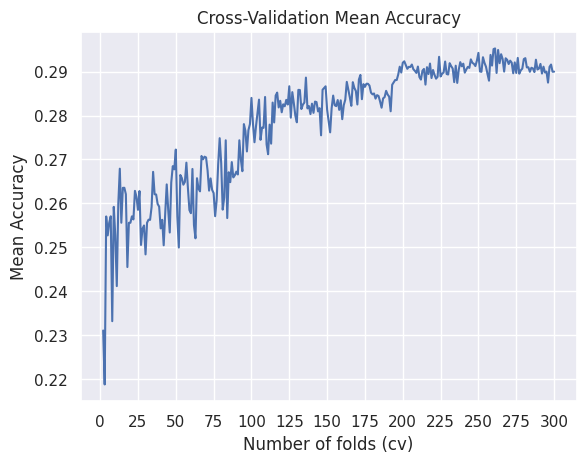

In [40]:
# Creazione del modello di albero decisionale
fTM_2 = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=2, min_samples_leaf=2,
                                          min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=4,min_impurity_decrease=0.0  )
# Addestramento del modello sui dati di training completi
eval_clf_with_plot_singleclf(range(2,301), fTM_2, X, y, 25 )

### Conclusioni
L'ottimizzazione con la beam search ha permesso di andare ad addestrare un albero ottimizzato che ci permette di battere la moda, tuttavia le sue performance non sono quelle di cui realmente avremmo bisogno per risolvere il problema che ci siamo posti, ma è pour sempre un inizio per l'investigazione su di altri modelli. Riamane da analizzare la crescita dell'accurancy all'aumentare dei fold.